<a href="https://colab.research.google.com/github/OJB-Quantum/Notebooks-for-Ideas/blob/main/Julia_Quantum_Optics_%2B_Examples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using Julia in Google Colab to visualize the propagation of a Gaussian wave packet running into a potential barrier.

In [23]:
using Pkg

In [ ]:
] add QuantumOptics PyPlot

In [ ]:
] add OrdinaryDiffEq Interpolations

In [26]:
using QuantumOptics
using PyPlot

In [27]:
xmin = -30
xmax = 30
Npoints = 200

b_position = PositionBasis(xmin, xmax, Npoints)
b_momentum = MomentumBasis(b_position)

Momentum(pmin=-10.471975511965978, pmax=10.471975511965978, N=200)

In [28]:
V0 = 1. # Height of Barrier
d = 5 # Width of Barrier
function V_barrier(x)
    if x < -d/2 || x > d/2
        return 0.
    else
        return V0
    end
end
V = potentialoperator(b_position, V_barrier)

Operator(dim=200x200)
  basis: Position(xmin=-30, xmax=30, N=200)sparse([93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109], [93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 200, 200)

In [29]:
Txp = transform(b_position, b_momentum)
Tpx = transform(b_momentum, b_position)
Hkin = LazyProduct(Txp, momentum(b_momentum)^2/2, Tpx)

LazyProduct(dim=200x200)
  basis: Position(xmin=-30, xmax=30, N=200)
  operators: 3

In [30]:
H = LazySum(Hkin, V)

LazySum(dim=200x200)
  basis: Position(xmin=-30, xmax=30, N=200)
  operators: 2

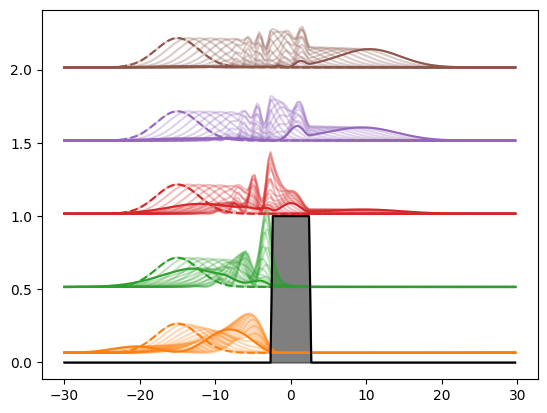

In [31]:
xpoints = samplepoints(b_position)

x0 = -15
sigma0 = 4
p0vec = [sqrt(0.1), 1, sqrt(2), sqrt(3), 2]
timecuts = 20

for i_p in 1:length(p0vec)
    p0 = p0vec[i_p]
    Ψ₀ = gaussianstate(b_position, x0, p0, sigma0)
    scaling = 1.0/maximum(abs.(Ψ₀.data))^2/5
    n0 = abs.(Ψ₀.data).^2 .* scaling

    tmax = 2*abs(x0)/(p0+0.2)
    T = collect(range(0.0, stop=tmax, length=timecuts))
    tout, Ψt = timeevolution.schroedinger(T, Ψ₀, H);

    offset = real.(expect(Hkin, Ψ₀))
    plot(xpoints, n0.+offset, "C$i_p--")
    for i=1:length(T)
        Ψ = Ψt[i]
        n = abs.(Ψ.data).^2 .* scaling
        plot(xpoints, n.+offset, "C$i_p", alpha=0.3)
    end
    nt = abs.(Ψt[timecuts].data).^2*scaling
    plot(xpoints, nt.+offset, "C$i_p")
end
y = V_barrier.(xpoints)
fill_between(xpoints, 0, y, color="k", alpha=0.5);
plot(xpoints, y, "k")

# Save with 300 DPI (although preview shown below will be a lower resolution)
savefig("sine_wave_300dpi.png", dpi=300)

This next section does a simulation of lasing, cooling, and trapping

In [32]:
using QuantumOptics
using PyPlot
using OrdinaryDiffEq
using Interpolations

In [33]:
n_p = 3 #photonen cutoff
N_a = 2 #number of atoms

#all variables and parameters are given in units of the following three
Γ = 1.0 #spontaneous emission rate
k = 1.0 #wavevector of the atom transition and the cavity field
ħ = 1.0 #Planck constant

ω_r = 0.1Γ #recoil frequency
Δ = 5.0Γ #cavity atom detuning Δ=ω_c-ω_a
g = 5.0Γ #coupling constant
κ = 20Γ #cavity loss rate
R = 8.0Γ #pump rate
λ = 2π/k #wavelength

#defining the basis of the Hilbertspace
b_c = FockBasis(n_p) #Fockbasis (cavity field)
b_a = SpinBasis(1//2) #2-level basis (atom)
b_all = tensor([b_a for i=1:N_a]...)⊗b_c #complete joint quantum basis

#defining operators
a = embed(b_all, N_a + 1, destroy(b_c)) #field annihilation operator
ad = dagger(a) #field creation operator
sm = [[embed(b_all, i, sigmam(b_a)) for i=1:N_a]...] #array of atom σ- operators
sp = dagger.(sm) #array of atom σ+ operators

#for faster computation we precalculate frequently used operator products
smad = [[sm[i]*ad for i=1:N_a]...]
spa = dagger.(smad)
spsm = sp.*sm
ada = ad*a
spsm_ar = [sp[i]*sm[j] for i=1:N_a, j=1:N_a]
spa_plus_smad = spa + smad

2-element Vector{Operator{CompositeBasis{Vector{Int64}, Tuple{SpinBasis{1//2, Int64}, SpinBasis{1//2, Int64}, FockBasis{Int64}}}, CompositeBasis{Vector{Int64}, Tuple{SpinBasis{1//2, Int64}, SpinBasis{1//2, Int64}, FockBasis{Int64}}}, SparseArrays.SparseMatrixCSC{ComplexF64, Int64}}}:
 Operator(dim=16x16)
  basis: [Spin(1/2) ⊗ Spin(1/2) ⊗ Fock(cutoff=3)]sparse([6, 8, 10, 1, 12, 3, 14, 5, 16, 7, 9, 11], [1, 3, 5, 6, 7, 8, 9, 10, 11, 12, 14, 16], ComplexF64[1.0 + 0.0im, 1.0 + 0.0im, 1.4142135623730951 + 0.0im, 1.0 + 0.0im, 1.4142135623730951 + 0.0im, 1.0 + 0.0im, 1.7320508075688772 + 0.0im, 1.4142135623730951 + 0.0im, 1.7320508075688772 + 0.0im, 1.4142135623730951 + 0.0im, 1.7320508075688772 + 0.0im, 1.7320508075688772 + 0.0im], 16, 16)
 Operator(dim=16x16)
  basis: [Spin(1/2) ⊗ Spin(1/2) ⊗ Fock(cutoff=3)]sparse([7, 8, 11, 12, 1, 2, 15, 16, 5, 6, 9, 10], [1, 2, 5, 6, 7, 8, 9, 10, 11, 12, 15, 16], ComplexF64[1.0 + 0.0im, 1.0 + 0.0im, 1.4142135623730951 + 0.0im, 1.4142135623730951 + 0.0im, 

In [34]:
H0 = Δ*ad*a #field and two-level atom Hamiltonian in rotaing frame

#Jump-Operators for Liouvillian
J = [[sm[i] for i=1:N_a]..., [sp[i] for i=1:N_a]..., a]
Jd = dagger.(J)

#rates of the dissipative processes
rates = [[Γ for i=1:N_a]..., [R for i=1:N_a]..., κ]

#function to update the Hammiltonian at every timestep
function f_q(t,ψ,u)
    #update H
    H_int = g*sum(cos.(u[1:N_a]*k).*spa_plus_smad)
    H = H0 + H_int
    #J and rates are always the same
    return H, J, Jd, rates
end

#function to update classical variables (Ehrenfest-theorem)
function f_cl!(du,u,ψ,t)
    #update position
    for i = 1:N_a
        du[i] = 2*ω_r*u[N_a + i]
    end
    #update momentum
    for i = 1:N_a
        du[N_a + i] = 1/k*2*g*sin(u[i]*k)*real(expect(spa[i],ψ))
    end
end

f_cl! (generic function with 1 method)

In [35]:
#initial state
d_atoms = 0.5λ #initial atom spacing
#initial classical position and momentum of the atoms:
u = ComplexF64[[i for i=0:N_a-1]*d_atoms...,([i for i=0:N_a-1]*0.1.+1.5)ħ*k...]
#initial semi-classical state: all spins down and 0 photons + classical variables
ψ = semiclassical.State(tensor([spindown(b_a) for i=1:N_a]...,fockstate(b_c, 0)),u)

#semi-classical time evolution
timestep = 0.1
t_max = 500
T=[0:timestep:t_max;]/Γ
t,ρt = semiclassical.master_dynamic(T,ψ,f_q,f_cl!)

([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9  …  499.1, 499.2, 499.3, 499.4, 499.5, 499.6, 499.7, 499.8, 499.9, 500.0], QuantumOptics.semiclassical.State{CompositeBasis{Vector{Int64}, Tuple{SpinBasis{1//2, Int64}, SpinBasis{1//2, Int64}, FockBasis{Int64}}}, Operator{CompositeBasis{Vector{Int64}, Tuple{SpinBasis{1//2, Int64}, SpinBasis{1//2, Int64}, FockBasis{Int64}}}, CompositeBasis{Vector{Int64}, Tuple{SpinBasis{1//2, Int64}, SpinBasis{1//2, Int64}, FockBasis{Int64}}}, Matrix{ComplexF64}}, Vector{ComplexF64}}[QuantumOptics.semiclassical.State{CompositeBasis{Vector{Int64}, Tuple{SpinBasis{1//2, Int64}, SpinBasis{1//2, Int64}, FockBasis{Int64}}}, Operator{CompositeBasis{Vector{Int64}, Tuple{SpinBasis{1//2, Int64}, SpinBasis{1//2, Int64}, FockBasis{Int64}}}, CompositeBasis{Vector{Int64}, Tuple{SpinBasis{1//2, Int64}, SpinBasis{1//2, Int64}, FockBasis{Int64}}}, Matrix{ComplexF64}}, Vector{ComplexF64}}(Operator(dim=16x16)
  basis: [Spin(1/2) ⊗ Spin(1/2) ⊗ Fock(cutoff=3)]
 0.0+0.0im  

In [36]:
#analyzing data
r = [[Float64[] for i=1:N_a]...] #postions of the particles at every timestep
p = [[Float64[] for i=1:N_a]...] #momenta of the particles
E_kin = [[Float64[] for i=1:N_a]...] #kinetic energies of the particles
n = Float64[] #number of photons in the cavity
popu = [[Float64[] for i=1:N_a]...] #excited state population of the particles
g2_0 = Float64[] #second order correlation function

for it=1:N_a
    r[it] = [ρt[i].classical[it] for i=1:length(ρt)]
    p[it] = [ρt[i].classical[N_a + it] for i=1:length(ρt)]
    E_kin[it] = [(ρt[i].classical[N_a + it])^2 for i=1:length(ρt)]
    popu[it] = [real(expect(spsm[it],ρt[i])) for i=1:length(ρt)]
end
n = [real(expect(ada,ρt[i])) for i=1:length(ρt)]
g2_0=[real(expect(ad*ad*a*a,ρt[i])/(expect(ada,ρt[i]))^2)
    for i=[2,[2:1:length(ρt);]...]]
E_kin_all = sum(E_kin); #overall kinetic energy

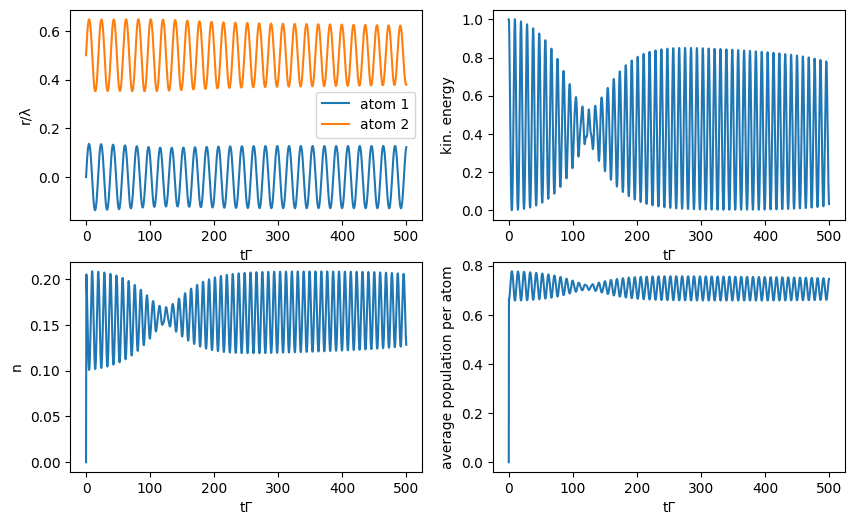

In [37]:
figure(figsize=(10, 6))
#position
subplot(221)
for i=1:N_a
    plot(t*Γ, r[i]/λ, label="atom $(i)")
end
xlabel("tΓ")
ylabel("r/λ")
legend()

#overall kinetic energy
subplot(222)
plot(t*Γ, E_kin_all/E_kin_all[1])
xlabel("tΓ")
ylabel("kin. energy")

#cavity photon number
subplot(223)
plot(t*Γ, n)
xlabel("tΓ")
ylabel("n")

#overall population per atom
subplot(224)
plot(t*Γ, sum(popu)/N_a)
xlabel("tΓ")
ylabel("average population per atom")

# Save with 300 DPI (although preview shown below will be a lower resolution)
savefig("Lasing_cooling-trapping_300dpi.png", dpi=300)

In [38]:
#calculate semiclassical spectrum
T_spec = [0:0.01:50;]
t1, ρt1 = semiclassical.master_dynamic(T_spec,ρt[end],f_q,f_cl!; alg=Tsit5())
r_spec = [[Float64[] for i=1:N_a]...] #postions of the particles at every timestep

#produce continous particle trajectories for further calculations
r_spline = []
for it=1:N_a
    r_spec[it] = [real(ρt1.classical[it]) for ρt1=ρt1]
    push!(r_spline, interpolate((t1,), r_spec[it], Gridded(Linear())))
end

function Ht(t,rho)
    u = [r_spline[it](t) for it=1:N_a]
    H_int = g*sum(cos.(u[1:N_a]*k).*spa_plus_smad)
    H = H0 + H_int
    return H, J, Jd, rates
end


aρ0 = a*ρt[end].quantum
τ, aρt = timeevolution.master_dynamic(T_spec,aρ0,Ht; alg=Tsit5())
corr = expect(ad, aρt)
ω, spec = timecorrelations.correlation2spectrum(τ, corr)
spec_0 = spec .- minimum(spec) #set spectrum minimum to 0
spec_0_norm = spec_0./maximum(spec_0)

5001-element Vector{Float64}:
 6.121144708401531e-10
 5.349064623124859e-10
 5.075442995381497e-10
 4.402643036552671e-10
 3.902133232696982e-10
 3.3930485781402995e-10
 2.821065410224353e-10
 2.4288702897964183e-10
 2.0312177428775201e-10
 1.7417095125018503e-10
 1.402252374249187e-10
 1.0371002629964084e-10
 5.970622012056547e-11
 ⋮
 1.4127816053965288e-9
 1.3386705535425568e-9
 1.2617766247864426e-9
 1.1951571887726513e-9
 1.124661928005842e-9
 1.0565014918100908e-9
 9.903703652317082e-10
 9.180996447859661e-10
 8.437463450002647e-10
 7.954012587270282e-10
 7.332718840545648e-10
 6.723064935534908e-10

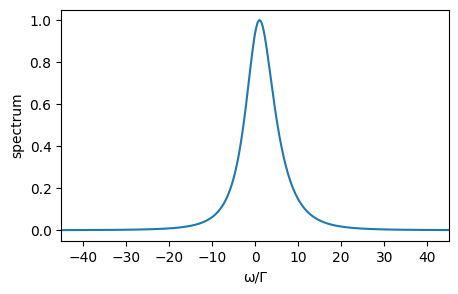

(-45.0, 45.0)

In [39]:
figure(figsize=(5, 3))
plot(ω/Γ, spec_0_norm)
xlabel("ω/Γ")
ylabel("spectrum")
xlim(xmin=-45, xmax=45)

This next section demonstrates a simulation of entangling two qubits

In [40]:
using QuantumOptics
using PyPlot

# Parameters
Ω = 0.5
t = [0:0.1:10;]

101-element Vector{Float64}:
  0.0
  0.1
  0.2
  0.3
  0.4
  0.5
  0.6
  0.7
  0.8
  0.9
  1.0
  1.1
  1.2
  ⋮
  8.9
  9.0
  9.1
  9.2
  9.3
  9.4
  9.5
  9.6
  9.7
  9.8
  9.9
 10.0

In [41]:
# Hamiltonian
b = SpinBasis(1//2)
H = Ω*(sigmap(b) ⊗ sigmam(b) + sigmam(b) ⊗ sigmap(b))

Operator(dim=4x4)
  basis: [Spin(1/2) ⊗ Spin(1/2)]sparse([3, 2], [2, 3], ComplexF64[0.5 + 0.0im, 0.5 + 0.0im], 4, 4)

In [42]:
ψ₀ = spindown(b) ⊗ spinup(b)
tout, ψₜ = timeevolution.schroedinger(t, ψ₀, H)

([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9  …  9.1, 9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9, 10.0], Ket{CompositeBasis{Vector{Int64}, Tuple{SpinBasis{1//2, Int64}, SpinBasis{1//2, Int64}}}, Vector{ComplexF64}}[Ket(dim=4)
  basis: [Spin(1/2) ⊗ Spin(1/2)]
 0.0 + 0.0im
 1.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im, Ket(dim=4)
  basis: [Spin(1/2) ⊗ Spin(1/2)]
                0.0 + 0.0im
 0.9987502603939152 + 0.0im
                0.0 - 0.04997916928640991im
                0.0 + 0.0im, Ket(dim=4)
  basis: [Spin(1/2) ⊗ Spin(1/2)]
                0.0 + 0.0im
 0.9950041653871255 + 0.0im
                0.0 - 0.09983341862461415im
                0.0 + 0.0im, Ket(dim=4)
  basis: [Spin(1/2) ⊗ Spin(1/2)]
                0.0 + 0.0im
 0.9887710777655703 + 0.0im
                0.0 - 0.14943813247470636im
                0.0 + 0.0im, Ket(dim=4)
  basis: [Spin(1/2) ⊗ Spin(1/2)]
                0.0 + 0.0im
 0.9800665776650753 + 0.0im
                0.0 - 0.19866934242673487im
                0.0 + 0

In [43]:
# Reduced density matrix
ρ_red = [ptrace(ψ ⊗ dagger(ψ), 1) for ψ=ψₜ]
S = [entropy_vn(ρ)/log(2) for ρ=ρ_red]

101-element Vector{ComplexF64}:
                   0.0 + 0.0im
  0.025193870141107817 + 0.0im
   0.08057237268279958 + 0.0im
   0.15433977224215056 + 0.0im
    0.2398545864053808 + 0.0im
   0.33222451694502864 + 0.0im
    0.4275017897027309 + 0.0im
    0.5223612829648715 + 0.0im
    0.6139457588529859 + 0.0im
    0.6997844697202811 + 0.0im
    0.7777478042508614 + 0.0im
    0.8460218488041004 + 0.0im
     0.903094884041355 + 0.0im
                       ⋮
   0.35569952940291116 + 0.0im
   0.26226959148915924 + 0.0im
   0.17464526254950458 + 0.0im
    0.0974382028182877 + 0.0im
   0.03672446668386078 + 0.0im
 0.0021674792344239667 + 0.0im
  0.015424537002340175 + 0.0im
   0.06482080694121836 + 0.0im
   0.13475090200764983 + 0.0im
   0.21785872523581065 + 0.0im
    0.3089271501502626 + 0.0im
    0.4038145215617121 + 0.0im

/usr/local/lib/python3.11/dist-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/usr/local/lib/python3.11/dist-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


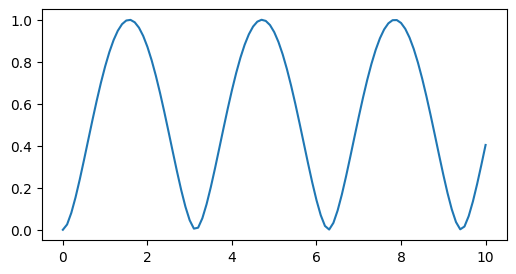

In [44]:
figure(figsize=(6, 3))
plot(tout, S)

# Save with 300 DPI (although preview shown below will be a lower resolution)
savefig("two qubit entanglement_300dpi.png", dpi=300)